In [3]:
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
nx.__version__

import numpy as np
from numpy import array
import tabulate

In [4]:
# TO SET
H = 30 # total simulation time, minutes
delta = 1 # clock interval
n_V = 5 # number of vehicles
drive_v = .02 # driving speed (leave the decimal at end)
walk_v = drive_v / 5. # walking speed (leave the decimal at end)

# TO DERIVE -- DO NOT TOUCH
h = 0 # current interval, starts at t=0
headway = H / float(n_V)

print tabulate.tabulate([("total time", "{} minutes".format(H)),
                         ("clock interval", "{} minute(s)".format(delta)),
                         ("# vehicles", n_V),
                         ("headway", "{} minutes / vehicle".format(headway)),
                         ("walking speed", "{} units / minute".format(walk_v)),
                         ("driving speed", "{} units / minute".format(drive_v))], headers=("parameter", "value"))

parameter       value
--------------  ---------------------
total time      30 minutes
clock interval  1 minute(s)
# vehicles      5
headway         6.0 minutes / vehicle
walking speed   0.004 units / minute
driving speed   0.02 units / minute


In [7]:
nodes = {"a": {"demand": 1, # this is a lambda parameter for a poisson for demands
               "pos": array([.2, .25])}, #[x,y] ranges between 0,1, for visualization purposes
         "b": {"demand": 1,
               "pos": array([.3, .25])},
         "c": { "demand": 1,
                "pos": array([.4, .25])},
         "d1": {"pos": array([.5, .2])},
         "d2": {"pos": array([.5, .25])},
         "d3": {"pos": array([.5, .3])},
         "e1": {"pos": array([.6, .2])},
         "e2": {"pos": array([.6, .25])},
         "e3": {"pos": array([.6, .3])},
         "f": {"pos": array([.7, .25])},
         "g": {"pos": array([.8, .25])},
         "h": {"pos": array([.9, .25])},
        }

demand_nodes = np.array([(k, n["demand"]) for k,n in nodes.iteritems() if "demand" in n])

# transition probability matrix -- uniform rn
transitions = {"a": {"d1": .11,
                     "d2": .11,
                     "d3": .11,
                     "e1": .11,
                     "e2": .11,
                     "e3": .11,
                     "f": .11,
                     "g": .11,
                     "h": .12},
               "b": {"d1": .11,
                     "d2": .11,
                     "d3": .11,
                     "e1": .11,
                     "e2": .11,
                     "e3": .11,
                     "f": .11,
                     "g": .11,
                     "h": .12},
               "c": {"d1": .11,
                     "d2": .11,
                     "d3": .11,
                     "e1": .11,
                     "e2": .11,
                     "e3": .11,
                     "f": .11,
                     "g": .11,
                     "h": .12}}
d_probs_by_origin = defaultdict(list)
d_names_by_origin = defaultdict(list)
for origin, probs in transitions.iteritems():
    for name, prob in probs.iteritems():
        d_probs_by_origin[origin].append(prob)
        d_names_by_origin[origin].append(name)

edges = {("a", "b"): {"weight": 2},
         ("b", "c"): {"weight": 2}, 
         ("c", "d1"): {"weight": 2},
         ("c", "d2"): {"weight": 2},
         ("c", "d3"): {"weight": 2},
         ("d1", "e1"): {"weight": 2},
         ("d2", "e2"): {"weight": 2},
         ("d3", "e3"): {"weight": 2},
         ("e1", "f"): {"weight": 2},
         ("e2", "f"): {"weight": 2},
         ("e3", "f"): {"weight": 2},
         ("f", "g"): {"weight": 2},
         ("g", "h"): {"weight": 2},}

def euclidean_distance(edge):
    return np.sqrt(np.sum((nodes[edge[1]]["pos"] - nodes[edge[0]]["pos"]) ** 2))

network = nx.DiGraph()    
for edge, _ in edges.iteritems():
    weight = {"dist": euclidean_distance(edge)}
    weight["weight"] = weight["dist"] / drive_v
    network.add_edge(edge[0], edge[1], **weight)
ordered_edges = list(nx.lexicographical_topological_sort(network))

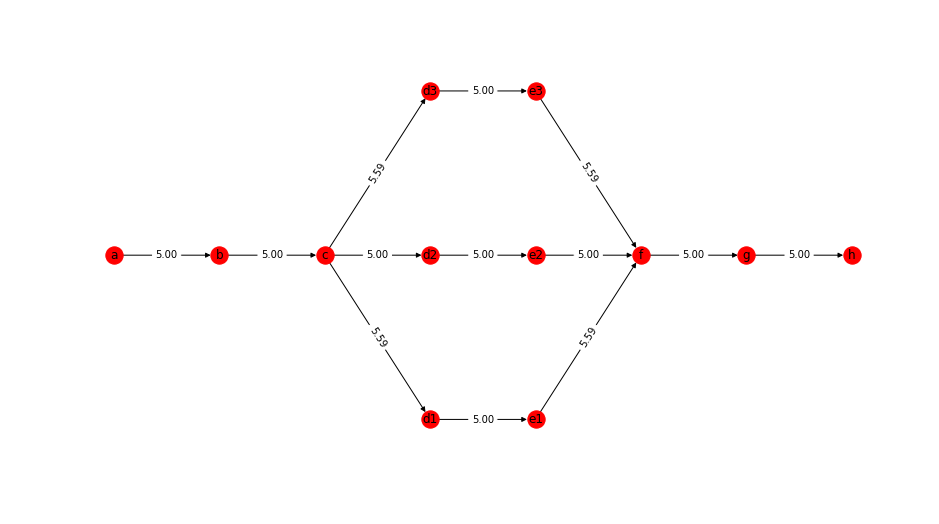

In [8]:
# construct pos dict for drawing
pos = {k: v["pos"] for k, v in nodes.iteritems()}

fig, ax = plt.subplots(figsize=(16, 9))
nx.draw(network, pos=pos, with_labels=True, ax = ax)
labels = {k: "{0:.2f}".format(v) for k, v in nx.get_edge_attributes(network,'weight').iteritems()}
_ = nx.draw_networkx_edge_labels(network,pos,edge_labels=labels, ax = ax)

In [13]:
# define simulation functions

def get_origins(demand_nodes):
    return np.random.poisson([d[1] for d in demand_nodes])
                              
def get_destinations(demand_nodes, origin_requests):
    o_d_pairs = []
    for (origin, _), n_passengers in zip(demand_nodes, origin_requests):
        dests = np.random.choice(d_names_by_origin[origin], size=n_passengers, p=d_probs_by_origin[origin])
        for dest in dests:
            o_d_pairs.append((origin, dest))
    return o_d_pairs


# see below for what state matrix looks like
def init_vehicle_state():
    FIRST_STOP = ordered_edges[0]
    NEXT_STOP = ordered_edges[1]
    return {"status": "at_stop",
     "current_stop": FIRST_STOP,
     "next_stop": NEXT_STOP,
     "et": network[FIRST_STOP][NEXT_STOP]["weight"],
     "passengers": set()}

In [10]:
from pulp import LpProblem, LpMaximize

In [11]:
# TODO: hack, fix the hardcoded paths
def solve_lp(vehicle_states, unserved_demand):
    PATHS = np.arange(3)
    

In [17]:
# actual simulation

np.random.seed(42) # seed rng

V = set(range(n_V)) # all vehicles
A_V = set([]) # active vehicles
I_V = V.copy() # inactive vehicles
h = 0

"""
example state matrix:
{1: {"status": "driving",
     "current_stop": "a",
     "next_stop": "b",
     "et": 10}}
"""
vehicle_states = {}
unserved_demand = set()

while h < H:
    print "h is {}".format(h)
    
    # figuring out new requests
    o_d_pairs = get_destinations(demand_nodes, get_origins(demand_nodes))
    unserved_demand = unserved_demand.union(set(o_d_pairs))
    print "demands: {}".format(unserved_demand)
    
    next_vehicle = I_V.pop()
    print "next vehicle is {}".format(next_vehicle)
    vehicle_states[next_vehicle] = init_vehicle_state()
    A_V = A_V.union(set([next_vehicle]))
    print "A_V is {}".format(A_V)
    print "I_V is {}".format(I_V)

    
    break
    h = h + delta

h is 0
demands: set([('a', 'h'), ('c', 'e3'), ('c', 'd2')])
next vehicle is 0
A_V is set([0])
I_V is set([1, 2, 3, 4])
